In [34]:
import rclpy
from rclpy.serialization import deserialize_message
from rosidl_runtime_py.utilities import get_message
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

rclpy.init()

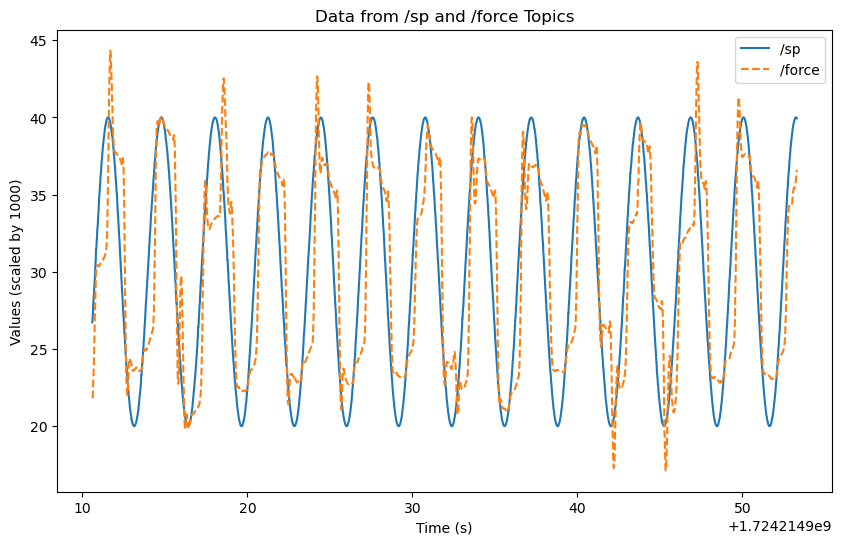

In [45]:
# ROS 2 노드 초기화
# rclpy.init()

# rosbag2의 SQLite 파일에 연결
# db_path = '/home/awear/ros2_data/rosbag2_2024_08_19-16_22_08/rosbag2_2024_08_19-16_22_08_0.db3' # spring달고 기본 PID rpdls 0.2, 0.01, 0.001
# db_path = '/home/awear/ros2_data/rosbag2_2024_08_19-18_35_29/rosbag2_2024_08_19-18_35_29_0.db3' # spring달고 기본 PID rpdls 0.2, 0.01, 0.001 + T:9 V:1.7
# db_path = '/home/awear/ros2_data/rosbag2_2024_08_21-13_35_10/rosbag2_2024_08_21-13_35_10_0.db3'  # spring달고 기본 PID rpdls 0.2, 0.01, 0.001 + 에러기준 th 3 co:1 + ll : F_L : -1, v:20
# db_path = '/home/awear/ros2_data/rosbag2_2024_08_19-18_38_48/rosbag2_2024_08_19-18_38_48_0.db3' # spring달고 기본 PID rpdls 0.2, 0.01, 0.001 + T:9 V:1.7 + th 0.5 co:1.1
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

def get_topic_data(topic_name, msg_type):
    cursor.execute(f"SELECT timestamp, data FROM messages WHERE topic_id = (SELECT id FROM topics WHERE name = '{topic_name}')")
    
    timestamps = []
    data_values = []

    msg_class = get_message(msg_type)
    
    for row in cursor.fetchall():
        timestamp = row[0] / 1e9  # 나노초를 초로 변환
        serialized_data = row[1]
        msg = deserialize_message(serialized_data, msg_class)
        timestamps.append(timestamp)
        data_values.append(msg.data / 1000.0)  # 값을 1000으로 나눔
    
    return np.array(timestamps), np.array(data_values)

# /sp 토픽 데이터 가져오기
sp_timestamps, sp_values = get_topic_data('/sp', 'std_msgs/msg/Int32')

# /force 토픽 데이터 가져오기
force_timestamps, force_values = get_topic_data('/force', 'std_msgs/msg/Int32')

conn.close()

# 데이터를 플롯
plt.figure(figsize=(10, 6))
plt.plot(sp_timestamps, sp_values, label='/sp')
plt.plot(force_timestamps, force_values, label='/force', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Values (scaled by 1000)')
plt.title('Data from /sp and /force Topics')
plt.legend()
plt.show()


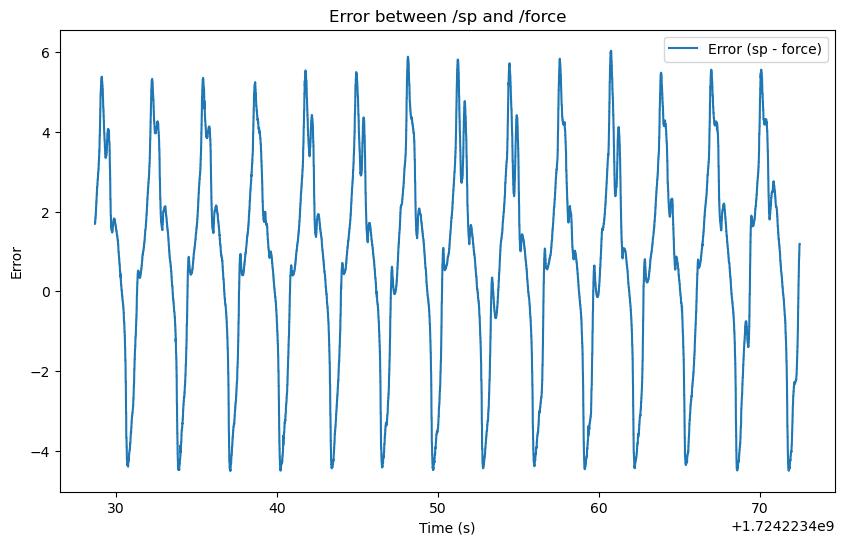

RuntimeError: Context must be initialized before it can be shutdown

In [44]:

# 에러 계산 (동일한 시간축을 사용한다고 가정)
min_length = min(len(sp_values), len(force_values))
error = sp_values[:min_length] - force_values[:min_length]

# 에러를 플롯
plt.figure(figsize=(10, 6))
plt.plot(sp_timestamps[:min_length], error, label='Error (sp - force)')
plt.xlabel('Time (s)')
plt.ylabel('Error')
plt.title('Error between /sp and /force')
plt.legend()
plt.show()

# ROS 2 노드 종료
rclpy.shutdown()

0.7994996223824236 2.6218229774158006


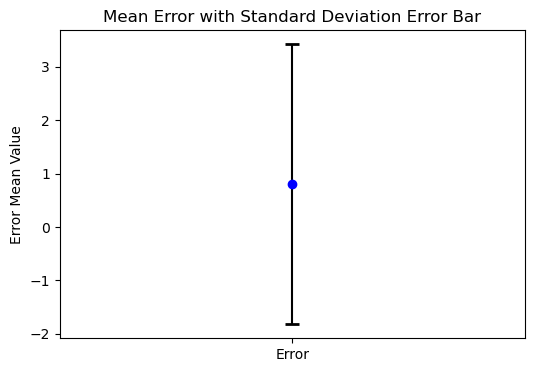

In [32]:
error_mean = np.mean(error)
error_std = np.std(error)
print(error_mean, error_std)

# 에러바 플롯 (단일 데이터 포인트)
plt.figure(figsize=(6, 4))
plt.errorbar(1, error_mean, yerr=error_std, fmt='o', capsize=5, capthick=2, color='blue', ecolor='black')
plt.xlim(0, 2)  # x축 범위를 설정하여 데이터 포인트가 중앙에 오도록 함
plt.xticks([1], ['Error'])  # x축 레이블 설정
plt.ylabel('Error Mean Value')
plt.title('Mean Error with Standard Deviation Error Bar')
plt.show()

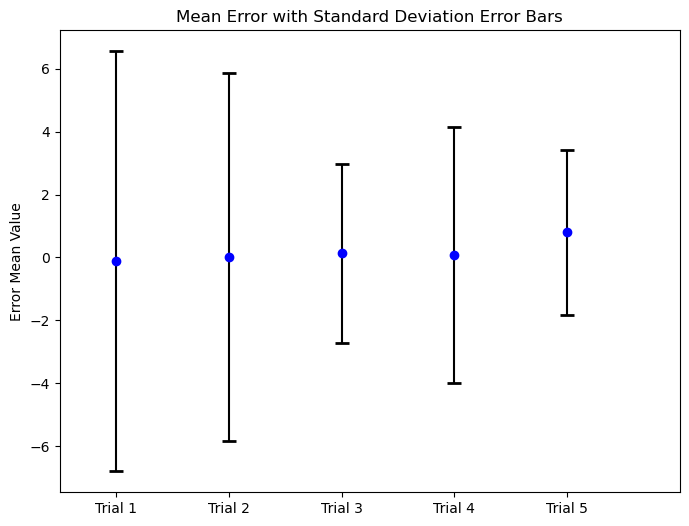

In [33]:
# 데이터
means = [-0.12366280417149494, 0.01485330156569091, 0.12627731092436975, 0.08300886839304727, 0.7994996223824236]
std_devs = [6.6821083284877565, 5.850608600930693, 2.853204238369815, 4.064276814440438, 2.6218229774158006]

# 플롯
plt.figure(figsize=(8, 6))
trials = [1, 2, 3, 4, 5]  # 각각의 trial을 1, 2, 3으로 지정

plt.errorbar(trials, means, yerr=std_devs, fmt='o', capsize=5, capthick=2, color='blue', ecolor='black')

plt.xlim(0.5, 6)  # x축 범위를 설정하여 데이터 포인트가 중앙에 오도록 함
plt.xticks(trials, ['Trial 1', 'Trial 2', 'Trial 3', 'Trial 4', 'Trial 5'])  # x축 레이블 설정
plt.ylabel('Error Mean Value')
plt.title('Mean Error with Standard Deviation Error Bars')

plt.show()